In [1]:
dataset_dir="images/"              

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import json
from nltk.tokenize import RegexpTokenizer
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.layers import GlobalAvgPool2D,Input,Dense,Dropout,Embedding,LSTM,Add
from keras.models import Model,load_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm_notebook
from time import time
from keras.preprocessing import sequence
from collections import Counter

Using TensorFlow backend.


# Loading the Data:

In [3]:
img_list=os.listdir(dataset_dir)

len(img_list)

31787

In [12]:
with open("captions.txt",'r',encoding="utf8") as f:
    data=f.read()
len(data)

12546846

# Storing the Captions for each image in dictionaries:

In [13]:
captions={}
data=data.split('\n')[1:]

for x in data:
    x=x.split('|')
    img_name=x[0]                                    
    
    if captions.get(img_name) is None:
        captions[img_name]=[]
            
    cap=x[-1]
    
    captions[img_name].append(cap)

In [14]:
captions

{}

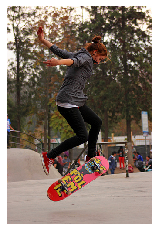

[' A red-haired girl is jumping in the air with a skateboard near her feet .', ' A girl is in midair while doing an elaborate trick on a skateboard .', ' A girl is jumping on her skateboard above a cement pavement .', ' A young woman is leaping in midair on a skateboard .', ' A girl is performing a skateboarding maneuver .']


In [20]:
#sample image and captions display:

sample_img_name=list(captions.keys())[30000]

img=cv2.imread(dataset_dir+sample_img_name)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

print(captions[sample_img_name])

# Preprocessing the Captions:
##### (Converting to lowercase , removing nos., special characters , adding special symbols to marks start and end of a caption)

In [21]:
def clean_text(text):
    
    '''This function cnverts all characters in the given text to 
       lowercase and also removes numbers and special characters.'''
    
    regex=RegexpTokenizer('[a-z 0-9]+')
    
    text=text.lower()
    text=regex.tokenize(text)
    text=''.join(text)
    text="<s>"+text+"</s>"            
    #<s> marks start of a caption, </s> marks end of the caption, so that model knows when to stop generating more words
    
    return text

In [22]:
for key in list(captions.keys()):
    for i in range(len(captions[key])):
        captions[key][i]=clean_text(captions[key][i])
    
captions

{'1000092795.jpg': ['<s> two young guys with shaggy hair look at their hands while hanging out in the yard </s>',
  '<s> two young  white males are outside near many bushes </s>',
  '<s> two men in green shirts are standing in a yard </s>',
  '<s> a man in a blue shirt standing in a garden </s>',
  '<s> two friends enjoy time spent together </s>'],
 '10002456.jpg': ['<s> several men in hard hats are operating a giant pulley system </s>',
  '<s> workers look down from up above on a piece of equipment </s>',
  '<s> two men working on a machine wearing hard hats </s>',
  '<s> four men on top of a tall structure </s>',
  '<s> three men on a large rig </s>'],
 '1000268201.jpg': ['<s> a child in a pink dress is climbing up a set of stairs in an entry way </s>',
  '<s> a little girl in a pink dress going into a wooden cabin </s>',
  '<s> a little girl climbing the stairs to her playhouse </s>',
  '<s> a little girl climbing into a wooden playhouse </s>',
  '<s> a girl going into a wooden buil

# Saving Captions in a txt file:

In [23]:
with open("captions.txt",'w') as f:
    f.write(str(captions))

# Loading saved Captions:

In [4]:
with open("captions.txt",'r',encoding='utf-8') as f:
    captions_str=f.read()
    
    json_acceptable_string=captions_str.replace("'","\"")
    captions=json.loads(json_acceptable_string)
    
captions

{'1000092795.jpg': ['<s> two young guys with shaggy hair look at their hands while hanging out in the yard </s>',
  '<s> two young  white males are outside near many bushes </s>',
  '<s> two men in green shirts are standing in a yard </s>',
  '<s> a man in a blue shirt standing in a garden </s>',
  '<s> two friends enjoy time spent together </s>'],
 '10002456.jpg': ['<s> several men in hard hats are operating a giant pulley system </s>',
  '<s> workers look down from up above on a piece of equipment </s>',
  '<s> two men working on a machine wearing hard hats </s>',
  '<s> four men on top of a tall structure </s>',
  '<s> three men on a large rig </s>'],
 '1000268201.jpg': ['<s> a child in a pink dress is climbing up a set of stairs in an entry way </s>',
  '<s> a little girl in a pink dress going into a wooden cabin </s>',
  '<s> a little girl climbing the stairs to her playhouse </s>',
  '<s> a little girl climbing into a wooden playhouse </s>',
  '<s> a girl going into a wooden buil

# Creating a Vocabulary of all words in the training and testing data:

In [5]:
vocab=[]

for key in captions.keys():
    for sentence in captions[key]:
        for word in sentence.split(' '):
            vocab.append(word)
        
len(vocab)

2286748

In [6]:
freq_cnt=dict(Counter(vocab))

In [7]:
#Sort this dictionary according to the freq count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filter
threshold=5
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
vocab=[x[0] for x in sorted_freq_cnt if x[0]!='']

In [8]:
len(vocab)

7330

In [9]:
word2idx={}
idx2word={}

for i,word in enumerate(vocab):
    word2idx[word]=i+1                                  #we are leaving index 0 to denote pad words
    idx2word[i+1]=word

In [10]:
len(idx2word),len(word2idx)

(7330, 7330)

 # Saving idx2word and word2idx mappings:

In [11]:
with open("word2idx.pkl",'wb') as f:
    pickle.dump(word2idx,f)
    
with open("idx2word.pkl",'wb') as f:
    pickle.dump(word2idx,f)

# Getting the caption of maximum length:
##### (We will specify the maxlen to be equal to the length of this caption, shorter captions will be padded with 0s and longer ones will be clipped (obviously, longer ones are not present))

In [12]:
maxlen=0
temp=[]
for caps in captions.values():
    for cap in caps:
        if len(cap.split(' '))>maxlen:
            temp.append(cap)
        maxlen=max(maxlen,len(cap.split(' ')))
        
maxlen

83

In [13]:
maxlen=30

# Image Feature Extraction:

###### (No need to run the below cells, image features have already been extracted and saved in train_data.pkl and test_data.pkl)

In [27]:
model=ResNet50(include_top=False,input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
__________

In [28]:
output_layer=GlobalAvgPool2D()(model.output)
model=Model(model.input,output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
__________

In [42]:
train_ftrs={}

for file in tqdm_notebook(os.listdir(dataset_dir)):
    
    img=cv2.imread(dataset_dir+file)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(224,224))
    img=preprocess_input(img)                           #this will scale the image in the same way that is done by resnet 50
    
    ftrs=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2])).flatten()
    train_ftrs[file]=ftrs
    
train_ftrs

C:\Users\akshay\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


{'1000092795.jpg': array([0.2491789 , 0.02534172, 0.13905513, ..., 0.4961374 , 0.32261184,
        0.57958174], dtype=float32),
 '10002456.jpg': array([0.2188034 , 0.3175936 , 0.7700884 , ..., 1.7839483 , 1.4062424 ,
        0.01958986], dtype=float32),
 '1000268201.jpg': array([0.07311771, 0.30572593, 0.3035351 , ..., 0.0969886 , 0.4588514 ,
        1.004784  ], dtype=float32),
 '1000344755.jpg': array([0.03520648, 0.11162247, 0.05716446, ..., 0.2908158 , 0.00714051,
        0.21898034], dtype=float32),
 '1000366164.jpg': array([0.02644992, 0.6296648 , 2.072234  , ..., 0.54009736, 0.09584989,
        1.0758455 ], dtype=float32),
 '1000523639.jpg': array([0.        , 1.9034117 , 0.        , ..., 0.04769187, 1.9042426 ,
        1.2949055 ], dtype=float32),
 '1000919630.jpg': array([0.293217  , 0.        , 0.00594532, ..., 0.4611375 , 0.8122459 ,
        0.12070078], dtype=float32),
 '10010052.jpg': array([0.03773836, 0.12814559, 0.17463167, ..., 0.3451475 , 0.11386438,
        0.1384163

In [43]:
with open("train_ftrs.pkl",'wb') as f:
    pickle.dump(train_ftrs,f)

# Loading the saved features:

In [14]:
with open('train_ftrs.pkl','rb') as f:
    train_ftrs=pickle.load(f)                                     #loading features of train images
    
train_ftrs

{'1000092795.jpg': array([0.2491789 , 0.02534172, 0.13905513, ..., 0.4961374 , 0.32261184,
        0.57958174], dtype=float32),
 '10002456.jpg': array([0.2188034 , 0.3175936 , 0.7700884 , ..., 1.7839483 , 1.4062424 ,
        0.01958986], dtype=float32),
 '1000268201.jpg': array([0.07311771, 0.30572593, 0.3035351 , ..., 0.0969886 , 0.4588514 ,
        1.004784  ], dtype=float32),
 '1000344755.jpg': array([0.03520648, 0.11162247, 0.05716446, ..., 0.2908158 , 0.00714051,
        0.21898034], dtype=float32),
 '1000366164.jpg': array([0.02644992, 0.6296648 , 2.072234  , ..., 0.54009736, 0.09584989,
        1.0758455 ], dtype=float32),
 '1000523639.jpg': array([0.        , 1.9034117 , 0.        , ..., 0.04769187, 1.9042426 ,
        1.2949055 ], dtype=float32),
 '1000919630.jpg': array([0.293217  , 0.        , 0.00594532, ..., 0.4611375 , 0.8122459 ,
        0.12070078], dtype=float32),
 '10010052.jpg': array([0.03773836, 0.12814559, 0.17463167, ..., 0.3451475 , 0.11386438,
        0.1384163

# Making a Custom Data Loader:

##### (Since the data is very big, we will load it in small batches)

In [15]:
def data_generator(img_ftrs,captions,batch_size,maxlen,word2idx):
    
    '''This function is used to load the data, one batch at a time'''
    
    x1=[]                              #will store the captions data
    x2=[]                              #will store the features of each image
    y_true=[]                          #will store the actual next word
    
    n=0                                  
    #to count no. of images generated for the current batch, will be reset to zero after generation of every batch
    
    for img,caps in captions.items():

        ftrs=img_ftrs[img]                                                     
        #feature vector of the current image generated using RESNET 50 model

        for cap in caps:
            cap=cap.split(' ')
            cap=[word2idx[word] for word in cap if word in word2idx]           #converting words to indices

            for i in range(1,len(cap)):
                xi=cap[:i]                              #first i words in the caption will be the current x_train (for captions)
                yi=cap[i]                               #ith word will be the y_true (actual truth for xi)

                xi=sequence.pad_sequences([xi],maxlen=maxlen,value=0,padding='post')[0]          
                #only pads 2d arrays, therefore we have enclosed xi within a list. Later 
                #we are fetching 0th element of the padded 2d list to get the padded 1d xi

                yi=to_categorical(yi,num_classes=len(vocab)+1)

                x1.append(xi)
                y_true.append(yi)
                x2.append(ftrs)

        n+=1
        if n==batch_size:                                #when to return a batch
            
            yield ([np.array(x2),np.array(x1)],np.array(y_true))
                
            #reset x1,x2,y_true and n
            x1=[]
            x2=[]
            y_true=[]
            n=0

# Creating an Embedding Matrix:
##### (This will be used in the embedding layer)
##### (We will use glove embedding to create the matrix)

In [17]:
with open('glove.6B.50d.txt','r',encoding='utf-8') as f:
    text=f.read()
    
len(text)

171337876

In [18]:
embeddings={}

for line in tqdm_notebook(text.split('\n')):
    
    line=line.split(' ')
    word=line[0]
    emb=line[1:]
    
    embeddings[word]=np.array(emb,dtype='float')
    
embeddings

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

In [19]:
embedding_matrix=np.zeros((len(vocab)+1,50))                   #each glove vector is of size 50                
embedding_matrix

#creating a matrix containing all 0s, we will replace the 0s with 
#actual embeddings of the words correspondng to the indices. If some 
#word in the vocabulary does not have a glove embedding, we will let 
#it's embedding in the embedding matrix be a row of all 0s.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
count=0
for i in range(len(vocab)+1):
    
    if idx2word.get(i) is None:
        continue
    
    word=idx2word[i]
    
    if embeddings.get(word) is None:
        count+=1
        continue
        
    emb=embeddings[word]
    embedding_matrix[i]=emb
    
embedding_matrix

#words which are not present in glove embedding and pad sequences are given an embedding of all zeroes

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.21705  ,  0.46515  , -0.46757  , ..., -0.043782 ,  0.41013  ,
         0.1796   ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [-0.33284  ,  0.38481  ,  1.4298   , ..., -0.23183  ,  0.37516  ,
         0.42673  ],
       [-1.0769   ,  0.0032013,  0.45585  , ...,  0.48349  , -0.36161  ,
         0.68875  ],
       [ 1.0278   ,  0.10632  ,  0.30326  , ..., -0.64574  ,  0.39394  ,
        -0.59202  ]])

# Creating a Model:

In [21]:
img_ftrs_shape=list(train_ftrs.values())[0].shape
img_ftrs_shape

(2048,)

In [22]:
img_captions_shape=(maxlen,)
img_captions_shape

(30,)

In [23]:
#Model for image features. This will take the image features as 
#input and output a 256 sized vector which encodes the images

input_img=Input(shape=img_ftrs_shape)
dropout_img=Dropout(0.4)(input_img)
encoded_img=Dense(256,activation='relu')(dropout_img)

W0416 09:16:33.556574  9364 deprecation.py:506] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [24]:
#Model for image captions. This will take partial captions
#as input and output an encoding of the captions

input_caps=Input(shape=img_captions_shape)
emb_out=Embedding(input_dim=len(vocab)+1,output_dim=50,mask_zero=True)(input_caps)               
#mask_zero=True means that index 0 is used for padding only

dropout_caps=Dropout(0.4)(emb_out)
encoded_caps=LSTM(256)(dropout_caps)

W0416 09:16:35.863994  9364 deprecation.py:323] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\keras\backend.py:3994: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [43]:
#Combining the Image and Captions Models:

comb=Add()([encoded_img,encoded_caps])                         #see documentation of Add layer

dense=Dense(256,activation="relu")(comb)
output=Dense(len(vocab)+1,activation='softmax')(dense)

model=Model(inputs=[input_img,input_caps],outputs=output)

In [44]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

#This will set the weights of the embedding layer same as embedding_matrix as embedding_matrix has been built using 
#pre-trained glove embeddings. So we are using transfer learning here and hence do not need to train the Embedding layer.

ValueError: Layer weight shape (9026, 50) not compatible with provided weight shape (7331, 50)

In [45]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       366550      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [46]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

# Training the Model:

In [16]:
model=load_model("model.h5")
model.summary()

W0416 09:41:54.648108  9232 deprecation.py:506] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0416 09:41:55.232079  9232 deprecation.py:323] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\keras\backend.py:3994: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0416 09:41:59.439947  9232 module_wrapper.py:139] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       366550      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [17]:
epochs=20
batch_size=3
steps_per_epoch=len(captions)//batch_size                

#steps per epoch specifies how many batches are there in one epoch 
#(it will be equal to (no. of images)//(batch_size))

In [18]:
for i in range(epochs):
    
    generator=data_generator(batch_size=batch_size,captions=captions,img_ftrs=train_ftrs,maxlen=maxlen,word2idx=word2idx)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps_per_epoch,verbose=2)
    model.save("model.h5")

Epoch 1/1


KeyboardInterrupt: 

# Getting the test features:

In [19]:
test_imgs=os.listdir("test_images/")

test_ftrs={}

for file in tqdm_notebook(test_imgs):
    
    img=cv2.imread("test_images/"+file)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(224,224))
    img=preprocess_input(img)                           #this will scale the image in the same way that is done by resnet 50
    
    ftrs=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2])).flatten()
    #remember that this model should be the feature extractor resnet (not the one loaded above)
    
    test_ftrs[file]=ftrs
    
test_ftrs

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[[150.061  , 137.22101, 130.32   ],
         [150.061  , 137.22101, 130.32   ],
         [150.061  , 137.22101, 130.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         ...

# Saving test_ftrs:

In [30]:
with open("test_ftrs.pkl",'wb') as f:
    pickle.dump(test_ftrs,f)

# Loading test_ftrs:

In [20]:
with open('test_ftrs.pkl','rb') as f:
    test_ftrs=pickle.load(f)                                     #loading features of train images
    
test_ftrs

{'dog-15-new-dog-fights-image-01-610x428.jpg': array([1.3009585 , 1.0436406 , 0.13498922, ..., 0.2158015 , 0.14877138,
        0.4593681 ], dtype=float32),
 'download (1).jpg': array([0.30261537, 0.04405293, 0.21711087, ..., 1.0226613 , 0.1972175 ,
        0.04530182], dtype=float32),
 'download (10).jpg': array([0.36456743, 0.8723928 , 0.0829258 , ..., 1.195001  , 0.8114096 ,
        0.        ], dtype=float32),
 'download (11).jpg': array([0.734747  , 0.11381305, 0.31674665, ..., 1.3789246 , 0.26999173,
        0.        ], dtype=float32),
 'download (12).jpg': array([0.25977734, 1.0259945 , 0.25659868, ..., 1.5951818 , 0.51806116,
        0.03173032], dtype=float32),
 'download (13).jpg': array([0.06412143, 0.04322098, 0.00434111, ..., 0.22487804, 0.07832023,
        0.02072687], dtype=float32),
 'download (2).jpg': array([0.10424159, 0.        , 0.12720172, ..., 0.10968751, 0.34998205,
        0.        ], dtype=float32),
 'download (3).jpg': array([0.1491859 , 0.32911745, 0.172889

# Loading the Trained Model:

In [21]:
model=load_model("model.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       366550      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

# Predictions:

In [22]:
def predict(ftrs):                                
    #ftrs represents the image features extracted using resnet and saved in test_data dictionary
    
    input_string='<s>'                            #intial input will be the start sequence
    
    for i in range(maxlen):                       #we will generate captions of maximum length equal to maxlen
        
        input_seq=[word2idx[word] for word in input_string.split(' ')]            
        #converting each word to a number (it's corresponding index)
        
        input_sequence=np.array(sequence.pad_sequences([input_seq],maxlen=maxlen,padding='post')[0])
        input_sequence=input_sequence.reshape((1,input_sequence.shape[0]))
        
        pred=model.predict([ftrs,input_sequence])
        idx=pred.argmax()                         #getting the index of the word which has maximum probability
        word=idx2word[idx]                        #getting the actual predicted word
        
        input_string+=' '+word
        
        if word=='</s>':                          #stop when end of sequence word is encountered
            break
    
    predicted_caption=input_string.split(' ')[1:-1]         #removing the start and end special words (<s> and </s>)
    predicted_caption=' '.join(predicted_caption)           #converting predicted caption to string
    
    return predicted_caption

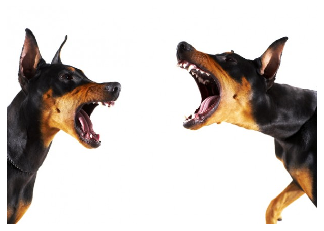

a black dog is running through a field


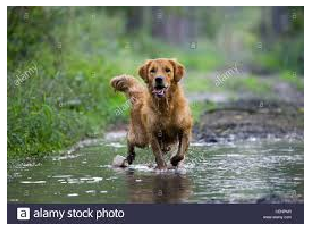

a brown dog is running through a field


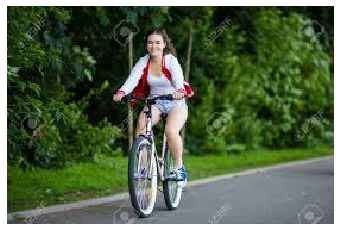

a man in a red shirt is walking down a road


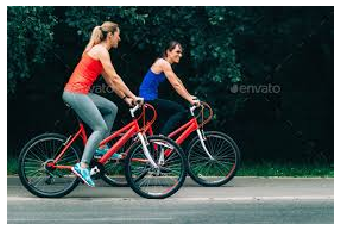

a man in a red shirt is riding a bike


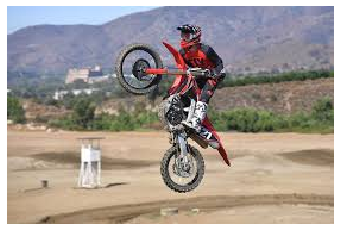

a man in a red shirt is riding a bike on a bike


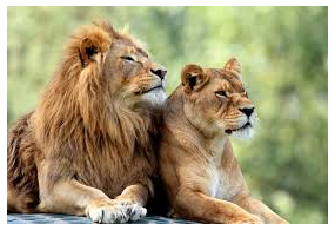

a brown dog is running through a field


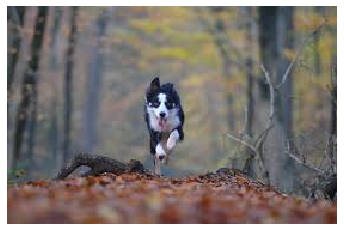

a dog is running through a field


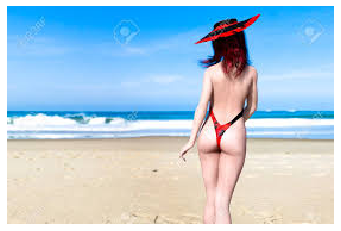

a young boy in a pink shirt is running through the water


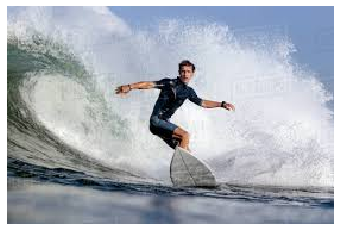

a man is surfing a wave on a surfboard


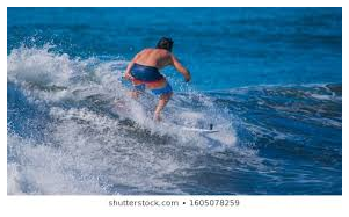

a man in a blue wetsuit is surfing in the water


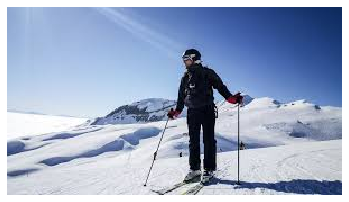

a person in a red jacket is walking down a path


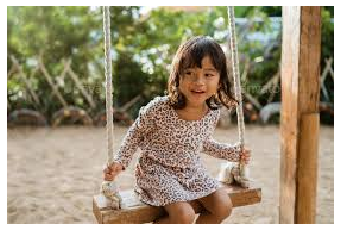

a little girl in a pink shirt is sitting on a bench with a toy


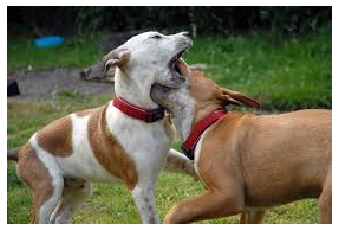

a brown dog is running through a field


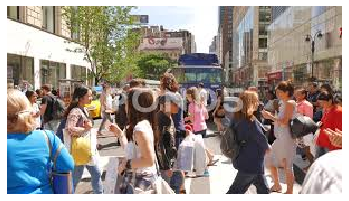

a group of people are walking down a street


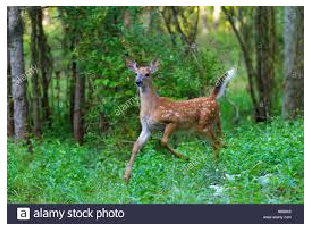

a brown dog is running through a field


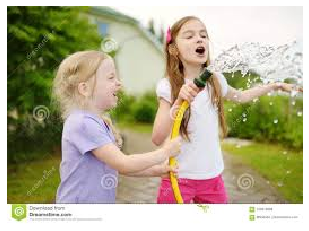

a young girl in a pink shirt is standing in a park


In [23]:
for img,ftrs in list(test_ftrs.items())[:50]:               #predicting for the first 50 images of the test set
    
    caption=predict(ftrs.reshape(1,ftrs.shape[0]))          
    #reshaping to (1,2048) because we need to send input in the form of batches, therefore, 1 image of size 2048
    
    img=cv2.imread('test_images/'+img)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    print(caption)